# Analyzing Stock Prices

Here we are working with data that was downloaded from Yahoo Finance using the yahoo_finance Python package. This data consists of the daily stock prices from 2007-1-1 to 2017-04-17 for several hundred stock symbols traded on the NASDAQ stock exchange, stored in the prices folder. The download_data.py script in the same folder as the Jupyter notebook was used to download all of the stock price data.

Each file in the prices folder is named for a given stock, and each contains the following information:

```date``` - the date that the data was collected <br>
```close``` - the closing price on that day <br>
```open``` - the opening price on that day <br>
```high``` - highest price the stock reached during the trading day <br>
```low``` - lowest price the stock reached during the trading day <br>
```volume``` - number of shares that were traded that day <br>

Lets read in all stock data and examine first few rows of Apple stock data

In [1]:
import pandas as pd
import os

data_dir = 'prices'

stocks = dict()
for file in os.listdir(data_dir):
    stocks[file[:-4]] = pd.read_csv(os.path.join(data_dir,file))

stocks['aapl'].head(5)

,date,close,open,high,low,volume
0,2007-01-03,83.800002,86.289999,86.579999,81.899999,309579900
1,2007-01-04,85.659998,84.050001,85.949998,83.820003,211815100
2,2007-01-05,85.049997,85.770000,86.199997,84.400002,208685400
3,2007-01-08,85.470000,85.959998,86.529998,85.280003,199276700
4,2007-01-09,92.570003,86.450003,92.979999,85.150000,837324600


Lets examine which stocks had the highest and lowest average closing prices:

In [2]:
close_prices = dict()
for key in stocks.keys():
    close_prices[key] = stocks[key]['close'].mean()
    
min_sym = min(close_prices, key=close_prices.get)
max_sym = max(close_prices, key=close_prices.get)
min_avg_price = close_prices[min_sym]
max_avg_price = close_prices[max_sym]

# print lowest and highest average stock symbols
print('Lowest average closing price: {}: $ {:.2f}'.format(min_sym, min_avg_price))
print('Highest average closing price: {}: $ {:.2f}'.format(max_sym, max_avg_price))


Lowest average closing price: blfs: $ 0.81
Highest average closing price: amzn: $ 275.13


We'd like to find which stock was the most traded. For this, we will create a dictionary that stores the stock symbol and volume for each date as the key:

In [3]:
stock_vol = dict()

# get list of dates
dates = list(stocks[max_sym].loc[:,'date'])

date = dates[0]
# get (vol, stock) pairs for each day of trading
# *consider only first 1000 days to save computation time 
for date in dates[0:1000]:
    stock_day = list()
    for key, df in stocks.items():
        #print(key)
        #print(df[df['date'] == str(date)]['volume'].item())
        try:
            vol = df[df['date'] == date]['volume'].item()
        except:
            vol = 0
        stock_day.append((vol,key))

        # assign daily trading information to dict
    stock_vol[date] = stock_day


Now we will extract the most traded stock for each day to examine trends in the market:

{'aapl': 972, 'bidu': 1, 'cy': 1, 'ebay': 4, 'cmcsa': 5, 'brcd': 3, 'amd': 1, 'csco': 13}


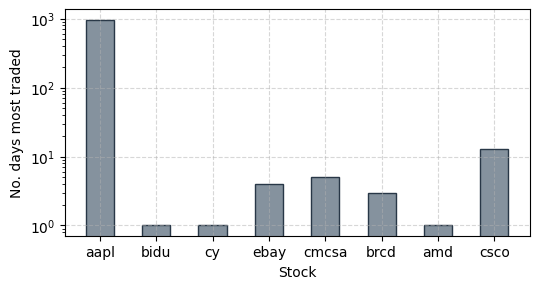

In [22]:
# get max stock for each day
from operator import itemgetter
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

most_traded = dict()
for key in stock_vol.keys():
    # find most traded stock
    most_traded[key] = max(stock_vol[key], key=itemgetter(0))

# create frequency dictionary to count the number of times a stock is most traded
days_most_traded = dict()
for key in most_traded.keys():
    stock_sym = most_traded[key][1]
    if stock_sym in days_most_traded.keys():
        days_most_traded[stock_sym] += 1
    else:
        days_most_traded[stock_sym] = 1

# ------------------------------------------
# generate histogram of most traded stocks
f = plt.figure(figsize = (6,3))
ax = f.add_subplot(1,1,1)
ax.bar(list(days_most_traded.keys()), 
       days_most_traded.values(), width = 0.5, 
       color='#85929E', edgecolor = '#283747')
ax.grid(True, alpha = 0.5, linestyle = '--')
ax.set_xlabel('Stock')
ax.set_ylabel('No. days most traded')
ax.set_yscale('log')
plt.show()
            

Clearly 'aapl' is the most traded stock during the period of data collection. We'd like to find days where the trading volume is unusually high. To do this, we will compute the total trading volume for each day and then sort by volume and report the top 10 days. 

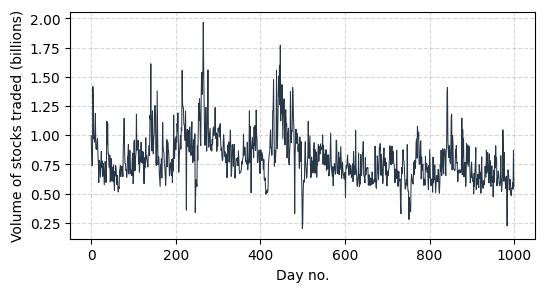

Top 10 trading days:
['2008-01-23', '2008-10-10', '2007-07-26', '2008-10-08', '2008-01-22', '2008-02-07', '2008-09-29', '2007-11-08', '2008-01-16', '2008-01-24']


In [64]:
trading_vol = dict()
for key in stock_vol.keys():
    trading_vol[key] = sum(i for i, j in stock_vol[key])
    
# plot trading volume per day
trades_per_day = list(zip(*trading_vol.items()))[1]

f = plt.figure(figsize = (6,3))
ax = f.add_subplot(1,1,1)
ax.plot(np.array(trades_per_day)/1e09, linewidth = 0.75, color = '#283747')
ax.grid(True, alpha = 0.5, linestyle = '--')
ax.set_xlabel('Day no.')
ax.set_ylabel('Volume of stocks traded (billions)')
plt.show()
    
# sort by trading volume
sorted_trading = sorted(trading_vol.items(), key=itemgetter(1), reverse = True)

top_10_days = []
for pair in sorted_trading:
    top_10_days.append(pair[0])
    
print('Top 10 trading days:')
print(top_10_days[0:10])

Finally, lets find the top 10 most and least profitable stock over the window of time where data was collected (limit to first 1,000 days). For each stock we will compute the difference between the initial closing price and the final closing price and normalize by the initial price to get a relative change in value.

In [68]:
rel_price_change = dict()
for key, df in stocks.items():
    rel_price_change[key] = (df.iloc[-1,1] - df.iloc[0,1])/df.iloc[0,1]*100

sorted_rel_price = sorted(rel_price_change.items(), key=itemgetter(1), reverse = True)

print('Top 10 most profitable stocks:')
print('Stock sym     Relative value change (%)')
print('---------------------------------------')
for pair in sorted_rel_price[0:10]:
    print('  {:4s}                {:.2f}'.format(pair[0],pair[1]))
    
print('Top 10 least profitable stocks:')
print('Stock sym     Relative value change (%)')
print('---------------------------------------')
for pair in sorted_rel_price[-10:-1]:
    print('  {:4s}                {:.2f}'.format(pair[0],pair[1]))


Top 10 most profitable stocks:
Stock sym     Relative value change (%)
---------------------------------------
  admp                7483.84
  adxs                4005.00
  arcw                3898.60
  blfs                2437.44
  amzn                2230.72
  anip                1707.36
  apdn                1549.67
  cui                 1525.16
  bcli                1339.21
  achc                1330.00
Top 10 least profitable stocks:
Stock sym     Relative value change (%)
---------------------------------------
  dest                -91.07
  clmt                -91.16
  evep                -93.05
  bbry                -93.18
  atlc                -93.22
  cetv                -95.63
  falc                -96.17
  cmls                -97.52
  dcth                -98.25
